In [1]:
from fastai2.vision.all import *
from fastai2.vision.core import _unscale_pnts
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.anchors import Anchors,AnchorLabeler,generate_detections,MAX_DETECTION_POINTS
from effdet.loss import DetectionLoss

In [2]:
# refactor after testing 
# Setting up effdet related config

model_config = get_efficientdet_config('tf_efficientdet_d0')
model = EfficientDet(model_config,pretrained_backbone=True)
model_config.num_classes = 1
model_config.image_size = 256
model.class_net = HeadNet(model_config,num_outputs=model_config.num_classes,norm_kwargs=dict(eps=.001,momentum=0.01))
path = Path('/home/heye0507/wheat_detection/data')

In [3]:
# Fastai bbox style is [x1,y1,x2,y2], given coco-style is [x1,y1,w,h]
def convert_fastai_bbox(box):
    x1,y1,w,h = box
    x2 = x1 + w
    y2 = y1 + h
    return [x1,y1,x2,y2]
    
def prep_bbox(df):
    images, bbox = df['image_id'],df['bbox']
    d = collections.defaultdict(list)
    for i,b in zip(images,bbox):
        d[i].append(convert_fastai_bbox([float(i) for i in b[1:-1].split(',')]))
    return d

In [4]:
def get_data(path,sz=224,bs=64):
    base = Path(path).parent
    df = pd.read_csv(path)
    img2bbox = prep_bbox(df)
    dblocks = DataBlock(
        blocks = (ImageBlock,BBoxBlock,BBoxLblBlock),
        splitter = RandomSplitter(),
        get_x = lambda o: str(base/'train')+'/'+o+'.jpg',
        get_y = [lambda o: img2bbox[o], lambda o: ['wheat' for i in range(len(img2bbox[o]))]],
        item_tfms = Resize(sz),
        batch_tfms=[Normalize.from_stats(*imagenet_stats)],
        n_inp=1
    )
    return dblocks.dataloaders(img2bbox.keys(),bs=bs)

In [5]:
dls = get_data(path/'train.csv',sz=256,bs=8)

In [6]:
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

In [7]:
# Setup anchor with gt_bbox & gt_lbl matching

anchors = Anchors(
    model_config.min_level,model_config.max_level,
    model_config.num_scales, model_config.aspect_ratios,
    model_config.anchor_scale, model_config.image_size
    )

In [8]:
def Effdet_Loss(preds, *targets):
    class_out, box_out = preds
    gt_bbox, gt_lbl = targets
    batch_sz = gt_bbox.shape[0]
    anchor_labeler = AnchorLabeler(anchors, model_config.num_classes,match_threshold=0.5)
    loss_func = DetectionLoss(model_config)

    # unpack fastai2 collated batch
    boxes, labels = [],[]
    perm = torch.LongTensor([1,0,3,2])

    # Effdet loss function looking for list of tensors, 
    '''
        batch_label_anchors
            batch size
            list of bounding box
            list of label (float)
    '''
    # can this part of code using broadcasting? 
    # currently after unpad they don't have same size
    # if unscale batchwise then un_pad, will have 128,128,128,128 needs to be removed itemwises.

    for i in range(batch_sz):
        box, lbl = un_pad(gt_bbox[i],gt_lbl[i])
        boxes.append(_unscale_pnts(box[:,perm],256).cpu()) # to tf style, yxyx
        labels.append(lbl.float().cpu())

    # match anchors to gt_bbox and gt_lbl

    cls_targets, box_targets, num_positivies = anchor_labeler.batch_label_anchors(
        batch_sz, boxes, labels
        )
    if torch.cuda.is_available():
        for i in range(len(cls_targets)):
            cls_targets[i] = cls_targets[i].cuda()
            box_targets[i] = box_targets[i].cuda()
    loss, class_loss, box_loss = loss_func(class_out, box_out, cls_targets, box_targets, num_positivies)
    return loss



In [9]:
learn = Learner(dls,model,loss_func=Effdet_Loss,model_dir='/home/heye0507/wheat_detection/model/').to_fp16()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=1.0964781722577754e-06)

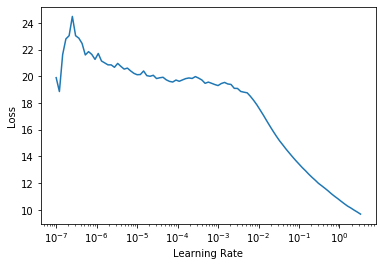

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(5,2e-2)

epoch,train_loss,valid_loss,time
0,16.200953,16.893120,02:37
1,7.158946,3.303419,02:37
2,6.263741,11.078637,02:36
3,5.988571,6.530420,02:37
4,4.938424,4.765682,02:36


# Test metrics

In [12]:
from numba import jit

In [13]:
# code from kaggle https://www.kaggle.com/pestipeti/competition-metric-details-script/data
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [14]:
b = dls.one_batch()
b[0].shape, b[1].shape, b[2].shape # img, bbox, bboxlbl

(torch.Size([8, 3, 256, 256]), torch.Size([8, 70, 4]), torch.Size([8, 70]))

In [15]:
preds = learn.model(b[0])

In [24]:
# Check caution lines and FIX it after testing

def my_mAP(preds,targs,img_size=256):
    class_out, box_out = preds
    gt_bbox, gt_lbl = targs
    batch_size = gt_bbox.shape[0]
    valid_img_precision = []
    
    
    ## unpack fastai2 collated batch
    boxes, labels = [],[]

    for i in range(batch_size):
        box, lbl = un_pad(gt_bbox[i],gt_lbl[i])
        box = _unscale_pnts(box,img_size).cpu()
        boxes.append(box.numpy()) 
        labels.append(lbl.float().cpu())
    ##########################################################
        
    ## prepare effDet format
    '''
        CAUTION: 
                model_config used as global var
                anchors used as global var
        
        res is a list of results in the format
        len(res) = MAX_DETECTION_POINTS, by default is 100, given dataset has max 116 bbox, suggests a higher num
        
        res: [[x,y,x,y,p,lbl],
              [],
              []...
             ]
        
        each of the item in res:
            0:4, bbox pred in xyxy pascal format
            5, confidence
            6, class (will always be 1. since only 1 class in the label)
                
        
    ''' 
    
    class_out,box_out,indices,classes = _post_process(model_config,class_out, box_out) # CAUTION
    for i in range(batch_size):
        class_out[i] = class_out[i].cpu()
        box_out[i] = box_out[i].cpu()
    res = _batch_detection(
        batch_size,class_out,
        box_out,anchors.boxes,
        indices,classes,
        tensor([1.]*batch_size),tensor([(img_size,img_size)]*batch_size)
    ) # CAUTION
    ##########################################################
        
    
    '''
        CAUTION:
                threshold and form is hardcode
    '''
    for i in range(batch_size):
        pred = res[i,:,0:4].detach().numpy() 
        valid_img_precision.append(calculate_precision(boxes[i],pred,threshold=0.5,form='pascal_voc')) # CAUTION
    return np.mean(valid_img_precision)
    

In [18]:
from effdet.bench import _post_process,_batch_detection

In [25]:
my_mAP(preds,(b[1],b[2]))

0.0016395368708878066